# Benchmarking notebook

Import required packages and functions

In [1]:
from benchmark_helpers import evaluate, boltzmann_energy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import makedirs

def load_J_and_h(n_visible_spins, alpha):
    J = np.genfromtxt(f'weights/W_ising_{n_visible_spins}_{alpha}_ti_W.csv', delimiter=',')
    h = np.genfromtxt(f'weights/W_ising_{n_visible_spins}_{alpha}_ti_b.csv', delimiter=',')
    return J, h

def make_bins(values, stddevs=3, num_bins=50):
    mean = np.mean(values)
    std = np.std(values)
    min_val = mean - stddevs * std
    max_val = mean + stddevs * std
    bins = np.linspace(min_val, max_val, num_bins + 1)
    return bins

# Define the system parameters

The system parameters correspond to the weights and biases included in `weights/`. The `n_visible_spins` corresponds to the number of visible spins in the system, and `alpha` corresponds to the ratio of hidden to visible spins of the RBM. The total number of spins of the Ising model is then given by `total_spins = n_visible_spins * (alpha + 1)`.

Below we load the connectivity matrix `J` and bias vector `h` for the Ising Hamiltonian, as well as the reference data for the observables, which we will use to compare to.

In [2]:
n_visible_spins = 16
alpha = 2
total_spins = n_visible_spins * (alpha + 1)

# Load the J connectivity matrix and h bias vector for the Ising Hamiltonian
J, h = load_J_and_h(n_visible_spins, alpha)

# Load included reference data
df_reference = pd.read_parquet(f'data/observables_{n_visible_spins}_{alpha}.parquet')

#### Load sampled states

Below you can provide your own `raw_states` array of shape (n_samples, total_spins) which are then processed by the `evaluate` function.

In [ ]:

df_raw_states = pd.read_parquet(f'data/states_{n_visible_spins}_{alpha}.parquet') # THIS IS AN EXAMPLE FILE, REPLACE WITH YOUR OWN DATA
raw_states = df_raw_states.values[:4000, :total_spins]

# Evaluate observables for the given states using the evaluate function
boltzmann_energies, quantum_energies, log_psi, sum_visible_spins, variational_energy, variational_energy_sem = evaluate(n_visible_spins=n_visible_spins, alpha=alpha, states=raw_states, J=J, h=h)

Percentage of states with zero magnetization: 54.05%
We will only consider the states with zero magnetization for the variational energy, as these are the ones that are relevant for the ground state of the system.
Percentage of states with zero magnetization is typically around 10-50%.
Quantum energy for alpha=2 and nspins=16: -0.7010847454312702
Standard error of the mean for the Quantum energy: 0.0004014719951145308


#### Evaluate the observables for sampled states
The `evaluate` function calculates relevant observables such as the `boltzmann_energy` corresponding to energy of Ising Hamiltonian and `quantum_energies` corresponding to the ground state of 2D antiferromagnetic quantum Heisenberg model.

In [ ]:
# Evaluate observables for the given states using the evaluate function
boltzmann_energies, quantum_energies, log_psi, sum_visible_spins, variational_energy, variational_energy_sem = evaluate(n_visible_spins=n_visible_spins, alpha=alpha, states=raw_states, J=J, h=h)

## Histogram comparing Boltzmann energy of sampled states with reference

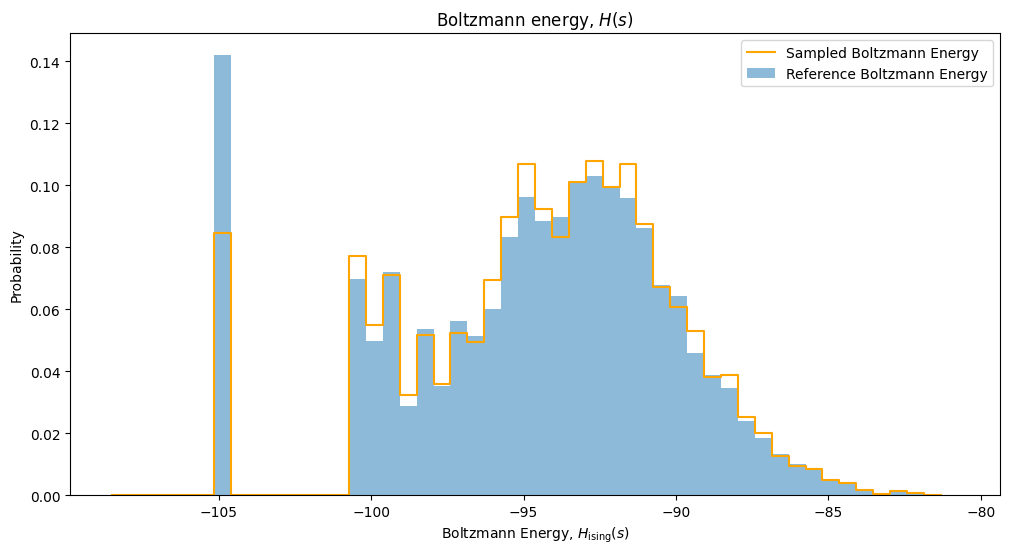

In [4]:

makedirs('plots', exist_ok=True)

##### Compare Boltzmann energy/Ising Hamiltonian with reference data #####

bins_boltzmann_energy = make_bins(df_reference['boltzmann_energy'], num_bins=50)

hist_reference, _ = np.histogram(df_reference['boltzmann_energy'], bins=bins_boltzmann_energy, density=True)
hist_samples, _ = np.histogram(boltzmann_energies, bins=bins_boltzmann_energy, density=True)

plt.figure(figsize=(12, 6))
plt.bar(bins_boltzmann_energy[:-1], hist_reference, width=np.diff(bins_boltzmann_energy), alpha=0.5, label='Reference Boltzmann Energy')
plt.step(bins_boltzmann_energy[:-1]-np.diff(bins_boltzmann_energy)/2, hist_samples, where='post', label='Sampled Boltzmann Energy', color='orange')

plt.xlabel('Boltzmann Energy, $H_\\mathrm{ising}(s)$')
plt.ylabel('Probability')
plt.title('Boltzmann energy, $H(s)$')
plt.legend()
plt.savefig(f'plots/boltzmann_energy_comparison_{n_visible_spins}_{alpha}.pdf')
plt.show()


## Histogram comparing Quantum energy of sampled states with reference

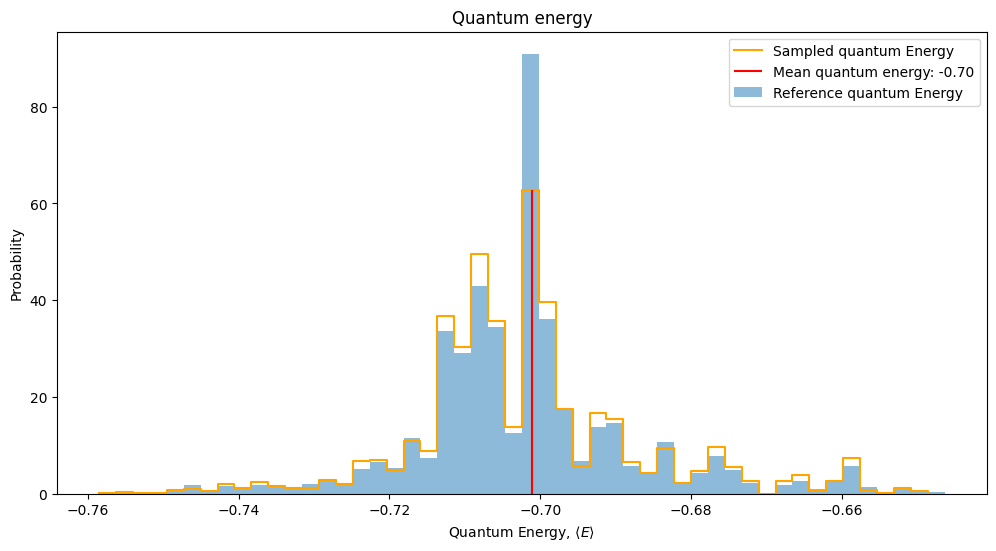

In [5]:

##### Compare quantum energies with reference data ##### 
reference_quantum_energy_mag0 = df_reference['quantum_energy'][df_reference['sum_visible_spins']==0] 
quantum_energies_mag0 = quantum_energies[sum_visible_spins==0]

bins_quantum_energy = make_bins(reference_quantum_energy_mag0, num_bins=50)
hist_reference_quantum, _ = np.histogram(reference_quantum_energy_mag0, bins=bins_quantum_energy, density=True)
hist_samples_quantum, _ = np.histogram(quantum_energies_mag0, bins=bins_quantum_energy, density=True)

plt.figure(figsize=(12, 6))
plt.bar(bins_quantum_energy[:-1], hist_reference_quantum, width=np.diff(bins_quantum_energy), alpha=0.5, label='Reference quantum Energy')
plt.step(bins_quantum_energy[:-1]-np.diff(bins_quantum_energy)/2, hist_samples_quantum, where='post', label='Sampled quantum Energy', color='orange')

mean_quantum_energy = np.mean(quantum_energies_mag0)
plt.vlines(mean_quantum_energy, 0, max(hist_samples_quantum), label=f'Mean quantum energy: {mean_quantum_energy:.2f}', color='red')

plt.xlabel('Quantum Energy, $\\langle E \\rangle$')
plt.ylabel('Probability')



plt.title('Quantum energy')
plt.legend()
plt.savefig(f'plots/quantum_energy_comparison_{n_visible_spins}_{alpha}.pdf')
plt.show()


# Relative error of quantum energy

In [6]:

##### Comparison score #####
reference_quantum_energy = np.mean(df_reference['quantum_energy'][df_reference['sum_visible_spins']==0])

relative_error_quantum_energy = np.abs(variational_energy - reference_quantum_energy) / np.abs(reference_quantum_energy)
print(f"Relative error in variational energy: {relative_error_quantum_energy:e}")

Relative error in variational energy: 3.410367e-04
